This script is to recode the parameters in Brown et al. (2018) for WEIRDO to enable the fitting of xf and cf


# Define functions used

In [29]:
calc_HC <- function(cf, xf, rr, np){
  #function to calculate hydraulic conductivity from cf xf
  
  # create a dataframe 
  df <- cbind.data.frame(rep(cf, length(rr)),rr,rep(xf, length(rr)), np)
  volumetricFlow <- apply(df, 1, function(x){
    aa <-as.numeric(x)
    # vp <- cf* r^xf * np
    y <- aa[1]*(aa[2]^aa[3])*aa[4]
    y
  })
  poreCapillarity <- volumetricFlow/1e6*3600
  kthetas <- cumsum(rev(poreCapillarity))
  out <- data.frame('meanPoreRadius' = rr, 
                    'No_of_Pores' = np,
                    'PoreCapillarity' = poreCapillarity,
                    'HydraulicConductivity' = rev(kthetas))
  return(out)
}

optimCFXF <- function(cfxf, rr, np, ksat){
  # function to be optimised to obtain best xf and cf values
  xf <- cfxf[1]
  cf <- cfxf[2]
  # create a dataframe 
  df <- cbind.data.frame(rep(cf, length(rr)),rr,rep(xf, length(rr)), np)
  volumetricFlow <- apply(df, 1, function(x){
    aa <-as.numeric(x)
    # vp <- cf* r^xf * np
    y <- aa[1]*(aa[2]^aa[3])*aa[4]
    y
  })
  poreCapillarity <- volumetricFlow/1e6*3600
  kcalc_sat <- sum(poreCapillarity)
  out <- abs(ksat-kcalc_sat)
  return(out)
}

# fit hermite splines to soil-water characteristic and the conductivity curve

In [3]:
## general set-up

In [16]:
mPotential <- -c(1,10, 1000, 150000, 6.09E7) # initialise psibub at -10

# diameters of the boundaries for the 11 pore cohorts
poreBoundaries <- poreDiameterUpper <- c(3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005)
poreDiameterLower <- c(poreDiameterUpper[2:11], 0)

# get water potential at pore boundaries
psiBoundary <- -30000/poreBoundaries

# get the mean pore radii of pore cohort
rr <- (poreDiameterUpper+poreDiameterLower)/4

# get the soil attributes 
# (This is based on SoilSet 4592 for KParamFit, no data for theta at AirDry, using 0.001 to ensure positive waterRetentionCurve)
thetas <- c(0.45, 0.45, 0.38, 0.20, 0.001)

#setting psibub here
psibub <- -100
mPotential[2] <- psibub

In [17]:
# fit the 5-point hermite spline 
waterRetentionC <- splinefun(x = mPotential, y = thetas, method = 'monoH.FC')

In [18]:
# get thetas at pore boundaries using the fitted spline
thetas.upperBound <- waterRetentionC(psiBoundary)
thetas.lowerBound <- c(thetas.upperBound[2:11],0)
# get the water volume in each pore cohort
waterVolumePore <- thetas.upperBound-thetas.lowerBound

# calculate number of pores in each pore cohort
numbersPore <- waterVolumePore/((pi * rr^2)/10^12)

# the hydraulic-flow model
poiseuille flow and capillarity
Arya et al. (1999)

In [19]:
# calculate the hydraulic conductivity of this soil using optimisation
# initialise at the value used in KParamFit in code block[32]
cfxf <- optim(c(3.5, 5e-12), optimCFXF, rr = rr, np = numbersPore, ksat = 0.2359)
while (cfxf$value != 0){
  cfxf <- optim(cfxf$par, optimCFXF, rr = rr, np = numbersPore, ksat = 0.2359)
}


`r cfxf$par` are the values for XF and CF respectively 

## calculate hydraulic conductivity

In [30]:
xf <- cfxf$par[1]
cf <- cfxf$par[2]

df.hc <- calc_HC(cf,xf, rr, numbersPore)

## plot results to inspect

### plot the spline

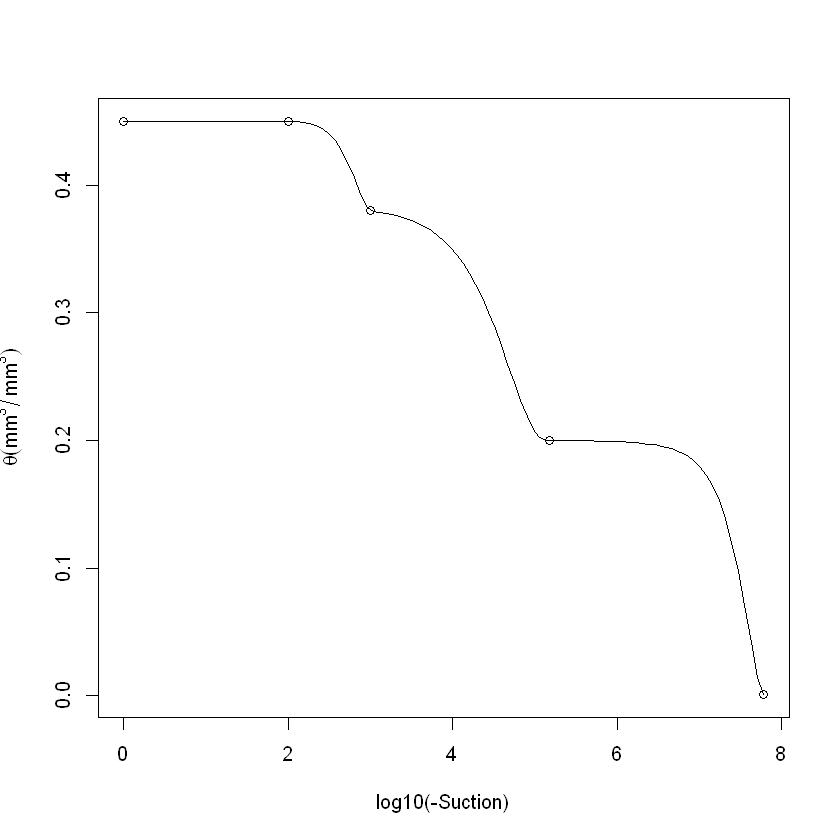

In [22]:
plot(log10(-mPotential), thetas, xlab = 'log10(-Suction)', 
     ylab = expression(theta*("mm"^3/'mm'^3)))
curve(waterRetentionC(-10^x, deriv = 0), add = T)

### plot hydraulic conductivity

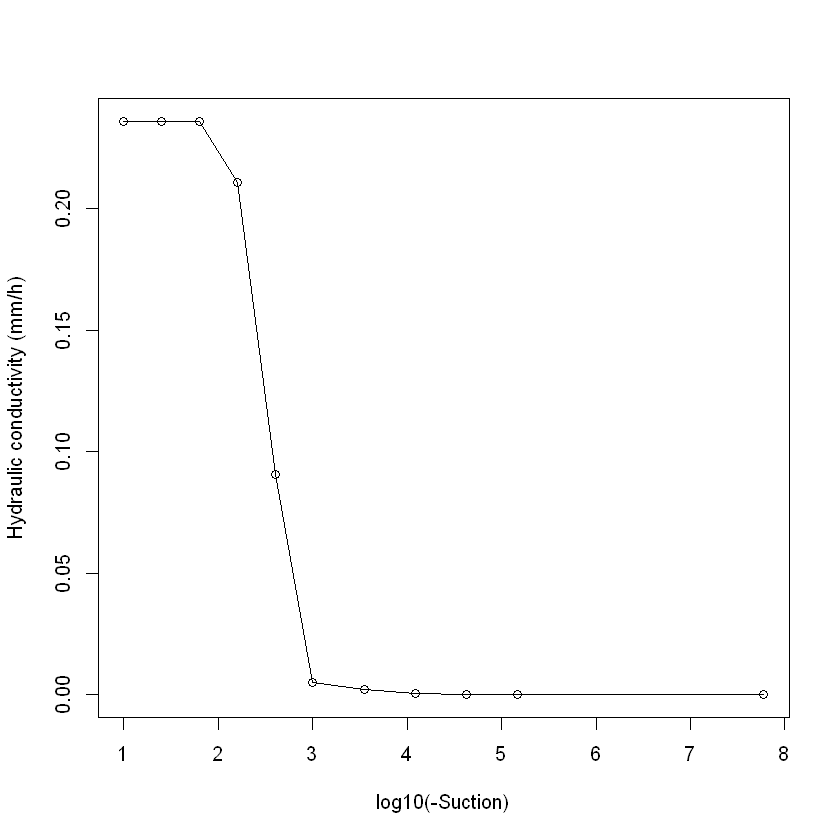

In [32]:
plot(log10(-psiBoundary), df.hc$HydraulicConductivity, xlab = 'log10(-Suction)', 
     ylab = 'Hydraulic conductivity (mm/h)')
lines(log10(-psiBoundary), df.hc$HydraulicConductivity)

In [26]:
cfxf$par

[1] 3.573885e+00 8.391023e-12

In [36]:
round(df.hc, digits = 4)

meanPoreRadius,No_of_Pores,PoreCapillarity,HydraulicConductivity
1048.5000,0.000000e+00,0.0000,0.2359
417.2500,0.000000e+00,0.0000,0.2359
166.0000,9.730410e+03,0.0253,0.2359
66.0000,1.246946e+06,0.1199,0.2106
26.2500,2.406438e+07,0.0858,0.0907
9.6500,3.031401e+07,0.0030,0.0050
2.7675,1.187723e+09,0.0014,0.0019
0.7942,3.775309e+10,0.0005,0.0006
0.2272,4.174784e+11,0.0001,0.0001
0.0506,2.469549e+13,0.0000,0.0000


### Compare with the two-region model of hydraulic conductivity used in SWIM3 (Huth et al., 2012)

#### define functions

In [38]:
# hydraulic conductivity Huth et al. 2012---------------
# calculating kmatrix, kDUL is assumed a notional value = 0.1 mm/day

calcKmatrix <- function(kdul = 0.1, tdul, tsat, b){
  kmat <- kdul/(tdul/tsat)^(2*b+3)
  kmat
}

calcb <- function(psi.dul, psi.ll, tdul, tll){
  b <- -log(psi.dul/psi.ll)/log(tdul/tll)
  b
}

calcP <- function(kdul = 0.1, ksat, kmat, tdul, tsat){
  p <- log(0.01*kdul/(ksat-kmat))/log(tdul/tsat)
  p
}

calcKtheta <- function(kmat, theta, tsat, b, ksat, p){
  k.theta <- kmat*((theta/tsat)^(2*b+3))+(ksat-kmat)*((theta/tsat)^p)
  k.theta
}

In [48]:
# soil 4592
bb <- calcb(1000,150000,0.38, 0.20)
kmat <- calcKmatrix(10^-2, 0.38, 0.45, bb)
pp <- calcP(10^-2, 0.2359, kmat, 0.38, 0.45)

kall <- calcKtheta(kmat, thetas.upperBound, 0.45, bb, 0.2359, pp)

In [49]:
kall

[1] 2.359000e-01 2.359000e-01 2.359000e-01 2.278035e-01 1.106721e-01
 [6] 1.010000e-02 6.504863e-03 1.461872e-03 1.484215e-05 6.499195e-08
[11] 1.630211e-49

In [50]:
df.hc$HydraulicConductivity

[1] 2.359000e-01 2.359000e-01 2.359000e-01 2.106268e-01 9.073025e-02
 [6] 4.967692e-03 1.945315e-03 5.813499e-04 8.070648e-05 1.746966e-05
[11] 8.054194e-12